In [78]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
from idqn.utils.confidence_interval import confidence_interval

experiment_name = "test2"
list_bellman_iterations_scope = [2, 6]
seeds = range(1, 2)

p = json.load(open(f"figures/{experiment_name}/parameters.json"))

n_bellman_iterations = p["n_epochs"] * p["n_bellman_iterations_per_epoch"]
n_states_x = p["n_states_x"]
n_states_v = p["n_states_v"]
n_seeds = len(seeds)
ticks_freq = 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extract data

In [79]:
optimal_q = np.load(f"figures/data/optimal/Q.npy")
optimal_v = np.load(f"figures/data/optimal/V.npy")

ifqi_q = np.zeros((len(list_bellman_iterations_scope), n_seeds, n_bellman_iterations + 1, n_states_x, n_states_v, 2))
ifqi_v = np.zeros((len(list_bellman_iterations_scope), n_seeds, n_bellman_iterations + 1, n_states_x, n_states_v))

for idx, bellman_iterations_scope in enumerate(list_bellman_iterations_scope):
    for idx_seed, seed in enumerate(seeds):
        ifqi_q[idx, idx_seed] = np.load(f"figures/{experiment_name}/iFQI/{bellman_iterations_scope}_Q_{seed}.npy")
        ifqi_v[idx, idx_seed] = np.load(f"figures/{experiment_name}/iFQI/{bellman_iterations_scope}_V_{seed}.npy")

### Distances with the optimal Q function

In [80]:
ifqi_q_mean = np.sqrt(np.mean(np.square(ifqi_q - optimal_q), axis=(3, 4, 5))).mean(axis=1)
ifqi_q_std = np.sqrt(np.mean(np.square(ifqi_q - optimal_q), axis=(3, 4, 5))).std(axis=1)
ifqi_q_confidence_interval = np.zeros((len(list_bellman_iterations_scope), 2, n_bellman_iterations + 1))

for idx in range(len(list_bellman_iterations_scope)):
    ifqi_q_confidence_interval[idx] = confidence_interval(ifqi_q_mean[idx], ifqi_q_std[idx], n_seeds)

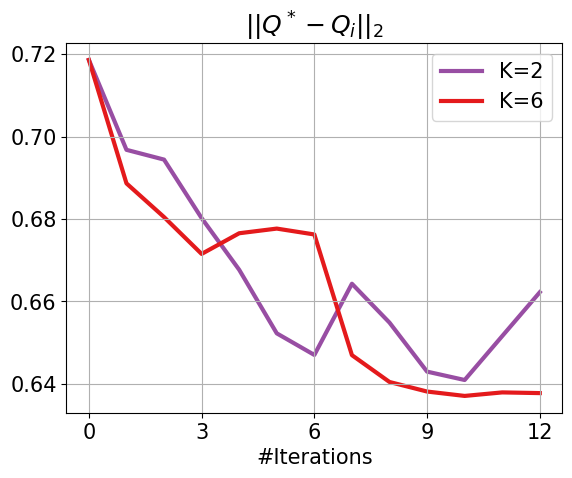

In [81]:
import matplotlib.pyplot as plt 
from experiments import colors

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(n_bellman_iterations + 1)

for idx, bellman_iterations_scope in enumerate(list_bellman_iterations_scope):
    plt.plot(iterations, ifqi_q_mean[idx], label=f"K={bellman_iterations_scope}", color=colors[f"{idx}"], zorder=1)
    plt.fill_between(iterations, ifqi_q_confidence_interval[idx, 0], ifqi_q_confidence_interval[idx, 1], color=colors[f"{idx}"], alpha=0.3)

plt.xticks(range(0, n_bellman_iterations + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.title(r"$|| Q^* - Q_i ||_2$")
plt.legend().set_zorder(3)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/{experiment_name}/distance_to_optimal_Q.pdf", bbox_inches='tight')

### Visualization of the policies at iteration max_bellman_iterations

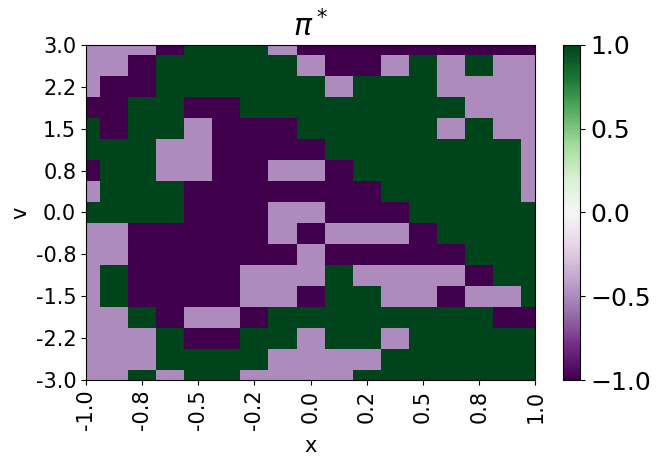

In [82]:
from idqn.utils.two_dimensions_mesh import TwoDimesionsMesh

max_pos = 1.0
max_velocity = 3.0

states_x = np.linspace(-max_pos, max_pos, n_states_x)
states_v = np.linspace(-max_velocity, max_velocity, n_states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v)

optimal_pi_weighted_average = (2 * ((optimal_q[:, :, 1] > optimal_q[:, :, 0])).astype(float) - 1) + (optimal_q[:, :, 1] == optimal_q[:, :, 0]).astype(float) / 2

q_visu_mesh.set_values(optimal_pi_weighted_average)
q_visu_mesh.show("$\pi^*$")
_ = plt.savefig(f"figures/{experiment_name}/optimal_pi.pdf", bbox_inches='tight')

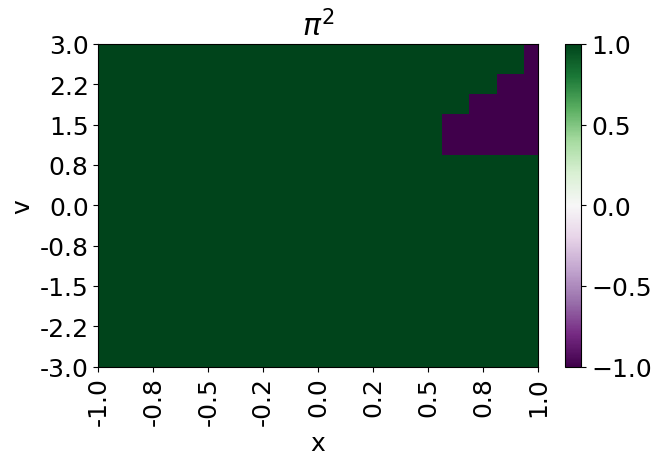

In [83]:
idx_to_show = 0
ifqi_left_q = ifqi_q[idx_to_show, :, -1, :, :, 0]
ifqi_right_q = ifqi_q[idx_to_show, :, -1, :, :, 1]
ifqi_pi_weighted_average = (2 * (ifqi_right_q > ifqi_left_q).mean(axis=0) - 1)

q_visu_mesh.set_values(ifqi_pi_weighted_average)
q_visu_mesh.show(f"$\pi^{list_bellman_iterations_scope[idx_to_show]}$")
_ = plt.savefig(f"figures/{experiment_name}/ifqi_pi_{list_bellman_iterations_scope[idx_to_show]}.pdf", bbox_inches='tight')

### Distance to optimal value function

In [84]:
ifqi_v_mean = np.sqrt(np.mean(np.square(ifqi_v - optimal_v), axis=(3, 4))).mean(axis=1)
ifqi_v_std = np.sqrt(np.mean(np.square(ifqi_v - optimal_v), axis=(3, 4))).std(axis=1)
ifqi_v_confidence_interval = np.zeros((len(list_bellman_iterations_scope), 2, n_bellman_iterations + 1))

for idx in range(len(list_bellman_iterations_scope)):
    ifqi_v_confidence_interval[idx] = confidence_interval(ifqi_v_mean[idx], ifqi_v_std[idx], n_seeds)

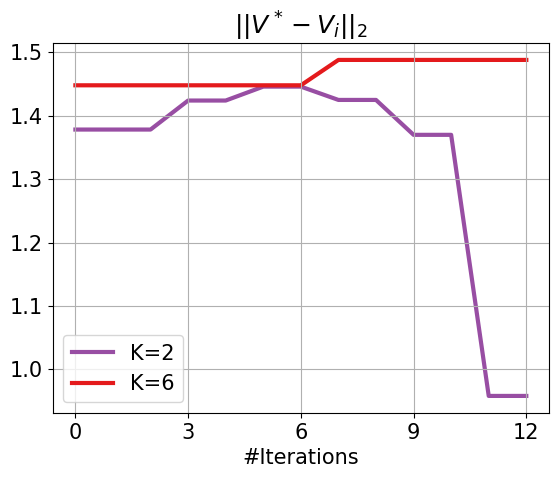

In [85]:
import matplotlib.pyplot as plt 
from experiments import colors

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(n_bellman_iterations + 1)

for idx, bellman_iterations_scope in enumerate(list_bellman_iterations_scope):
    plt.plot(iterations, ifqi_v_mean[idx], label=f"K={bellman_iterations_scope}", color=colors[f"{idx}"], zorder=1)
    plt.fill_between(iterations, ifqi_v_confidence_interval[idx, 0], ifqi_v_confidence_interval[idx, 1], color=colors[f"{idx}"], alpha=0.3)

plt.xticks(range(0, n_bellman_iterations + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.title(r"$|| V^* - V_i ||_2$")
plt.legend().set_zorder(3)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/{experiment_name}/distance_to_optimal_V.pdf", bbox_inches='tight')

### Value functions

In [86]:
ifqi_v_mean_performance = np.mean(ifqi_v, axis=(3, 4)).mean(axis=1)
ifqi_v_std_performance = np.mean(ifqi_v, axis=(3, 4)).std(axis=1)
ifqi_v_confidence_interval_performance = np.zeros((len(list_bellman_iterations_scope), 2, n_bellman_iterations + 1))

for idx in range(len(list_bellman_iterations_scope)):
    ifqi_v_confidence_interval_performance[idx] = confidence_interval(ifqi_v_mean_performance[idx], ifqi_v_std_performance[idx], n_seeds)

optimal_v_performance = (optimal_v).mean()

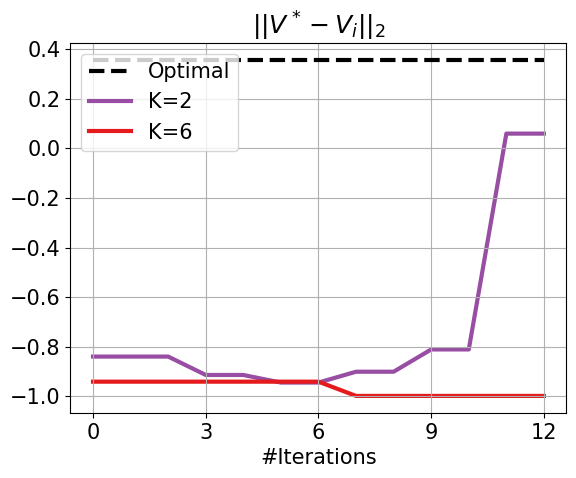

In [87]:
import matplotlib.pyplot as plt 
from experiments import colors

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(n_bellman_iterations + 1)

plt.hlines(optimal_v_performance, 0, n_bellman_iterations, color="black", linestyle="--", label="Optimal")

for idx, bellman_iterations_scope in enumerate(list_bellman_iterations_scope):
    plt.plot(iterations, ifqi_v_mean_performance[idx], label=f"K={bellman_iterations_scope}", color=colors[f"{idx}"], zorder=1)
    plt.fill_between(iterations, ifqi_v_confidence_interval_performance[idx, 0], ifqi_v_confidence_interval_performance[idx, 1], color=colors[f"{idx}"], alpha=0.3)

plt.xticks(range(0, n_bellman_iterations + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.title(r"$|| V^* - V_i ||_2$")
plt.legend().set_zorder(3)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/{experiment_name}/V.pdf", bbox_inches='tight')

### Visualization of the last value functions

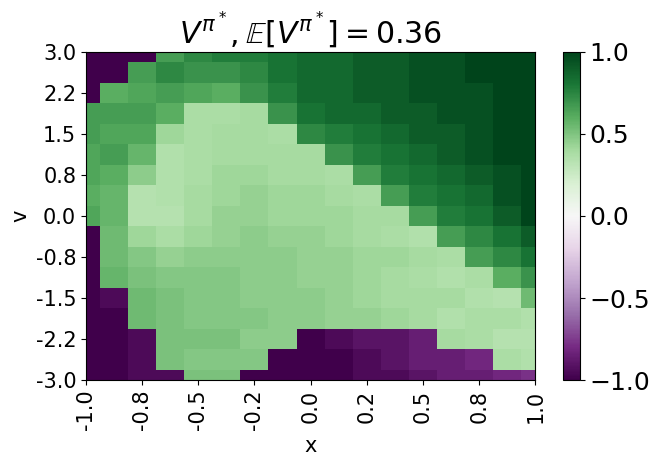

In [88]:
from idqn.utils.two_dimensions_mesh import TwoDimesionsMesh

max_pos = 1.0
max_velocity = 3.0

states_x = np.linspace(-max_pos, max_pos, n_states_x)
states_v = np.linspace(-max_velocity, max_velocity, n_states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v)

q_visu_mesh.set_values(optimal_v)
q_visu_mesh.show(r"$V^{\pi^*}, \mathbb{E}\left[ V^{\pi^*} \right] =$" + str(np.round(np.mean(optimal_v), 2)))
_ = plt.savefig(f"figures/{experiment_name}/optimal_V.pdf", bbox_inches='tight')

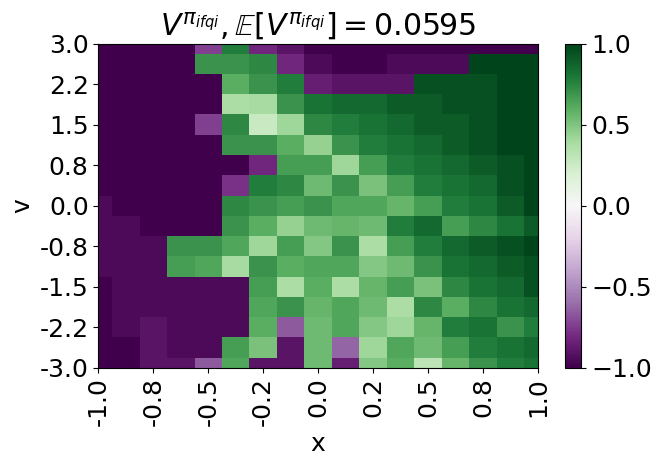

In [89]:
idx_to_show = 0
ifqi_last_v = ifqi_v[idx_to_show, :, -1].mean(axis=0)

q_visu_mesh.set_values(ifqi_last_v)
q_visu_mesh.show(r"$V^{\pi_{ifqi}}, \mathbb{E}\left[ V^{\pi_{ifqi}} \right] =$" + f"{np.round(np.mean(ifqi_last_v), 4)}")
_ = plt.savefig(f"figures/{experiment_name}/ifqi_V_{list_bellman_iterations_scope[idx_to_show]}.pdf", bbox_inches='tight')